#Jhillian Cabos
CPE22S3

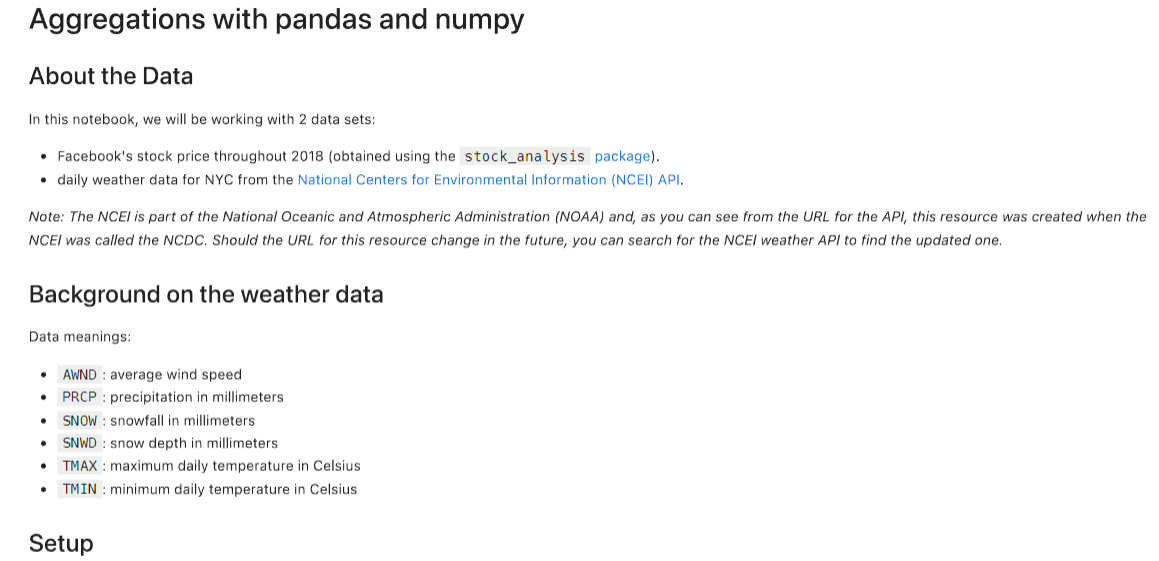

In [2]:
import numpy as np
import pandas as pd
weather = pd.read_csv('weather_by_station.csv', index_col='date', parse_dates=True)
weather.head()

,datatype,station,value,station_name
date,,,,
2018-01-01,PRCP,GHCND:US1CTFR0039,0.0,"STAMFORD 4.2 S, CT US"
2018-01-01,PRCP,GHCND:US1NJBG0015,0.0,"NORTH ARLINGTON 0.7 WNW, NJ US"
2018-01-01,SNOW,GHCND:US1NJBG0015,0.0,"NORTH ARLINGTON 0.7 WNW, NJ US"
2018-01-01,PRCP,GHCND:US1NJBG0017,0.0,"GLEN ROCK 0.7 SSE, NJ US"
2018-01-01,SNOW,GHCND:US1NJBG0017,0.0,"GLEN ROCK 0.7 SSE, NJ US"


In [5]:
fb = pd.read_csv('fb_2018.csv', index_col='date', parse_dates=True).assign(
trading_volume=lambda x: pd.cut(x.volume, bins=3, labels=['low', 'med', 'high'])
)
fb.head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903,low
2018-01-03,181.88,184.78,181.3300,184.67,16886563,low
2018-01-04,184.90,186.21,184.0996,184.33,13880896,low
2018-01-05,185.59,186.90,184.9300,186.85,13574535,low
2018-01-08,187.20,188.90,186.3300,188.28,17994726,low


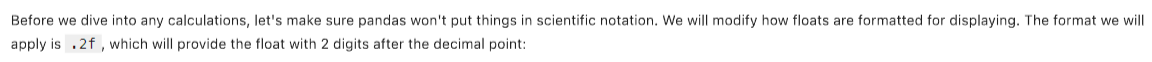

In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

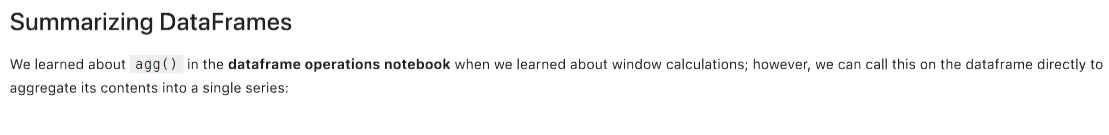

In [7]:
fb.agg({
'open': np.mean,
'high': np.max,
'low': np.min,
'close': np.mean,
'volume': np.sum
})

open            171.45
high            218.62
low             123.02
close           171.51
volume   6949682394.00
dtype: float64

We can use this to find the total snowfall and precipitation recorded in Central Park in 2018

In [8]:
weather.query(
'station == "GHCND:USW00094728"'
).pivot(columns='datatype', values='value')[['SNOW', 'PRCP']].sum()

datatype
SNOW   1007.00
PRCP   1665.30
dtype: float64

This is equivalent to passing 'sum' to agg() :

In [9]:
weather.query(
'station == "GHCND:USW00094728"'
).pivot(columns='datatype', values='value')[['SNOW', 'PRCP']].agg('sum')

datatype
SNOW   1007.00
PRCP   1665.30
dtype: float64

Note that we aren't limited to providing a single aggregation per column. We can pass a list, and we will get a dataframe back instead of a series. nan values are placed
where we don't have a calculation result to display:

In [10]:
fb.agg({
'open': 'mean',
'high': ['min', 'max'],
'low': ['min', 'max'],
'close': 'mean'
})


,open,high,low,close
mean,171.45,NaN,NaN,171.51
min,NaN,129.74,123.02,NaN
max,NaN,218.62,214.27,NaN


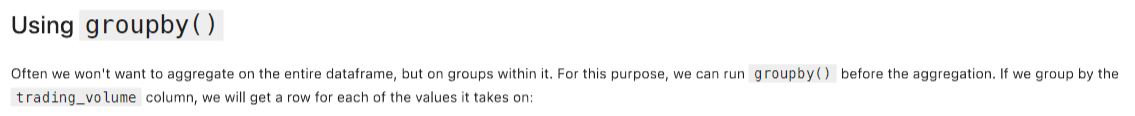

In [11]:
fb.groupby('trading_volume').mean()

,open,high,low,close,volume
trading_volume,,,,,
low,171.36,173.46,169.31,171.43,24547207.71
med,175.82,179.42,172.11,175.14,79072559.12
high,167.73,170.48,161.57,168.16,141924023.33


After we run the groupby() , we can still select columns for aggregation:

In [12]:
fb.groupby('trading_volume')['close'].agg(['min', 'max', 'mean'])

,min,max,mean
trading_volume,,,
low,124.06,214.67,171.43
med,152.22,217.50,175.14
high,160.06,176.26,168.16


We can still provide a dictionary specifying the aggregations to perform, but passing a list for a column will result in a hierarchical index for the columns:

In [13]:
fb_agg = fb.groupby('trading_volume').agg({
'open': 'mean',
'high': ['min', 'max'],
'low': ['min', 'max'],
'close': 'mean'
})
fb_agg

open   high           low         close
                 mean    min    max    min    max   mean
trading_volume                                          
low            171.36 129.74 216.20 123.02 212.60 171.43
med            175.82 162.85 218.62 150.75 214.27 175.14
high           167.73 161.10 180.13 149.02 173.75 168.16

The hierarchical index in the columns looks like this

In [14]:
fb_agg.columns

MultiIndex([( 'open', 'mean'),
            ( 'high',  'min'),
            ( 'high',  'max'),
            (  'low',  'min'),
            (  'low',  'max'),
            ('close', 'mean')],
           )

Using a list comprehension, we can join the levels (in a tuple) with an _ at each iteration:

In [15]:
fb_agg.columns = ['_'.join(col_agg) for col_agg in fb_agg.columns]
fb_agg.head()

,open_mean,high_min,high_max,low_min,low_max,close_mean
trading_volume,,,,,,
low,171.36,129.74,216.20,123.02,212.60,171.43
med,175.82,162.85,218.62,150.75,214.27,175.14
high,167.73,161.10,180.13,149.02,173.75,168.16


We can group on datetimes despite them being in the index if we use a Grouper :

In [16]:
weather['2018-10'].query('datatype == "PRCP"').groupby(
pd.Grouper(freq='D')
).mean().head()

<ipython-input-16-708005da144d>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  weather['2018-10'].query('datatype == "PRCP"').groupby(
<ipython-input-16-708005da144d>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).mean().head()


,value
date,
2018-10-01,0.01
2018-10-02,2.23
2018-10-03,19.69
2018-10-04,0.32
2018-10-05,0.97


In [17]:
weather.query('datatype == "PRCP"').groupby(
['station_name', pd.Grouper(freq='Q')]
).sum().unstack().sample(5, random_state=1)

<ipython-input-17-b1fc85a2870b>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).sum().unstack().sample(5, random_state=1)


value                                 
date                        2018-03-31 2018-06-30 2018-09-30 2018-12-31
station_name                                                           
WANTAGH 1.1 NNE, NY US          279.90     216.80     472.50     277.20
STATEN ISLAND 1.4 SE, NY US     379.40     295.30     438.80     409.90
SYOSSET 2.0 SSW, NY US          323.50     263.30     355.50     459.90
STAMFORD 4.2 S, CT US           338.00     272.10     424.70     390.00
WAYNE TWP 0.8 SSW, NJ US        246.20     295.30     620.90     422.00

Note that we can use filter() to exclude some groups from aggregation. Here, we only keep groups with 'NY' in the group's name attribute, which is the station ID in
this case:

In [18]:
weather.groupby('station').filter( # station IDs with NY in them
lambda x: 'NY' in x.name
).query('datatype == "SNOW"').groupby('station_name').sum().squeeze()

<ipython-input-18-795f9edd7920>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).query('datatype == "SNOW"').groupby('station_name').sum().squeeze()


station_name
ALBERTSON 0.2 SSE, NY US         1087.00
AMITYVILLE 0.1 WSW, NY US         434.00
AMITYVILLE 0.6 NNE, NY US        1072.00
ARMONK 0.3 SE, NY US             1504.00
BROOKLYN 3.1 NW, NY US            305.00
CENTERPORT 0.9 SW, NY US          799.00
ELMSFORD 0.8 SSW, NY US           863.00
FLORAL PARK 0.4 W, NY US         1015.00
HICKSVILLE 1.3 ENE, NY US         716.00
JACKSON HEIGHTS 0.3 WSW, NY US    107.00
LOCUST VALLEY 0.3 E, NY US          0.00
LYNBROOK 0.3 NW, NY US            325.00
MASSAPEQUA 0.9 SSW, NY US          41.00
MIDDLE VILLAGE 0.5 SW, NY US     1249.00
NEW HYDE PARK 1.6 NE, NY US         0.00
NEW YORK 8.8 N, NY US               0.00
NORTH WANTAGH 0.4 WSW, NY US      471.00
PLAINEDGE 0.4 WSW, NY US          610.00
PLAINVIEW 0.4 ENE, NY US         1360.00
SADDLE ROCK 3.4 WSW, NY US        707.00
STATEN ISLAND 1.4 SE, NY US       936.00
STATEN ISLAND 4.5 SSE, NY US       89.00
SYOSSET 2.0 SSW, NY US           1039.00
VALLEY STREAM 0.6 SE, NY US       898.00
WAN

Let's see which months have the most precipitation. First, we need to group by day and average the precipitation across the stations. Then we can group by month and sum
the resulting precipitation. We use nlargest() to give the 5 months with the most precipitation:

In [19]:
weather.query('datatype == "PRCP"').groupby(
pd.Grouper(freq='D')
).mean().groupby(pd.Grouper(freq='M')).sum().value.nlargest()

<ipython-input-19-978bd538e3b2>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).mean().groupby(pd.Grouper(freq='M')).sum().value.nlargest()


date
2018-11-30   210.59
2018-09-30   193.09
2018-08-31   192.45
2018-07-31   160.98
2018-02-28   158.11
Name: value, dtype: float64

Perhaps the previous result was surprising. The saying goes "April showers bring May flowers"; yet April wasn't in the top 5 (neither was May for that matter). Snow will count
towards precipitation, but that doesn't explain why summer months are higher than April. Let's look for days that accounted for a large percentage of the precipitation in a
given month.
In order to do so, we need to calculate the average daily precipitation across stations and then find the total per month. This will be the denominator. However, in order to
divide the daily values by the total for their month, we will need a Series of equal dimensions. This means we will need to use transform() :

In [20]:
weather.query('datatype == "PRCP"').rename(
dict(value='prcp'), axis=1
).groupby(pd.Grouper(freq='D')).mean().groupby(
pd.Grouper(freq='M')
).transform(np.sum)['2018-01-28':'2018-02-03']

<ipython-input-20-951bb02e735d>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).groupby(pd.Grouper(freq='D')).mean().groupby(


,prcp
date,
2018-01-28,69.31
2018-01-29,69.31
2018-01-30,69.31
2018-01-31,69.31
2018-02-01,158.11
2018-02-02,158.11
2018-02-03,158.11


Notice how we have the same value repeated for each day in the month it belongs to. This will allow us to calculate the percentage of the monthly precipitation that occurred
each day and then pull out the largest values:

In [21]:
weather\
.query('datatype == "PRCP"')\
.rename(dict(value='prcp'), axis=1)\
.groupby(pd.Grouper(freq='D')).mean()\
.assign(
total_prcp_in_month=lambda x: x.groupby(
pd.Grouper(freq='M')
).transform(np.sum),
pct_monthly_prcp=lambda x: x.prcp.div(
x.total_prcp_in_month
)
).nlargest(5, 'pct_monthly_prcp')

<ipython-input-21-e5da73b4d9c0>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .groupby(pd.Grouper(freq='D')).mean()\


,prcp,total_prcp_in_month,pct_monthly_prcp
date,,,
2018-10-12,34.77,105.63,0.33
2018-01-13,21.66,69.31,0.31
2018-03-02,38.77,137.46,0.28
2018-04-16,39.34,140.57,0.28
2018-04-17,37.30,140.57,0.27


transform() can be used on dataframes as well. We can use it to easily standardize the data:

In [22]:
fb[['open', 'high', 'low', 'close']].transform(
lambda x: (x - x.mean()).div(x.std())
).head()

,open,high,low,close
date,,,,
2018-01-02,0.32,0.41,0.41,0.50
2018-01-03,0.53,0.57,0.60,0.66
2018-01-04,0.68,0.65,0.74,0.64
2018-01-05,0.72,0.68,0.78,0.77
2018-01-08,0.80,0.79,0.85,0.84


#Pivot tables and crosstabs
We saw pivots in before; however, we weren't able to provide any aggregations. With pivot_table() , we get the mean by default as the aggfunc . In its simplest form,
we provide a column to place along the columns:

In [23]:
fb.pivot_table(columns='trading_volume')

trading_volume,low,med,high
close,171.43,175.14,168.16
high,173.46,179.42,170.48
low,169.31,172.11,161.57
open,171.36,175.82,167.73
volume,24547207.71,79072559.12,141924023.33


By placing the trading volume in the index, we get the aggregation from the first example in the group by section above:

In [24]:
fb.pivot_table(index='trading_volume')

,close,high,low,open,volume
trading_volume,,,,,
low,171.43,173.46,169.31,171.36,24547207.71
med,175.14,179.42,172.11,175.82,79072559.12
high,168.16,170.48,161.57,167.73,141924023.33


With pivot() , we also weren't able to handle multi-level indices or indices with repeated values. For this reason we haven't been able to put the weather data in the wide
format. The pivot_table() method solves this issue:

In [25]:
weather.reset_index().pivot_table(
index=['date', 'station', 'station_name'],
columns='datatype',
values='value',
aggfunc='median'
).reset_index().tail()


datatype,date,station,station_name,AWND,DAPR,MDPR,PGTM,PRCP,SNOW,SNWD,...,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11
28740,2018-12-31,GHCND:USW00054787,"FARMINGDALE REPUBLIC AIRPORT, NY US",5.00,NaN,NaN,2052.00,28.70,NaN,NaN,...,15.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28741,2018-12-31,GHCND:USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,25.90,0.00,0.00,...,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28742,2018-12-31,GHCND:USW00094741,"TETERBORO AIRPORT, NJ US",1.70,NaN,NaN,1954.00,29.20,NaN,NaN,...,8.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28743,2018-12-31,GHCND:USW00094745,"WESTCHESTER CO AIRPORT, NY US",2.70,NaN,NaN,2212.00,24.40,NaN,NaN,...,11.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28744,2018-12-31,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",4.10,NaN,NaN,NaN,31.20,0.00,0.00,...,12.50,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can use the pd.crosstab() function to create a frequency table. For example, if we want to see how many low-, medium-, and high-volume trading days Facebook
stock had each month, we can use crosstab:

In [26]:
pd.crosstab(
index=fb.trading_volume,
columns=fb.index.month,
colnames=['month'] # name the columns index
)

month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,20,19,15,20,22,21,18,23,19,23,21,19
med,1,0,4,1,0,0,2,0,0,0,0,0
high,0,0,2,0,0,0,1,0,0,0,0,0


We can normalize with the row or column totals with the normalize parameter. This shows percentage of the total:

In [27]:
pd.crosstab(
index=fb.trading_volume,
columns=fb.index.month,
colnames=['month'],
normalize='columns'
)

month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,0.95,1.00,0.71,0.95,1.00,1.00,0.86,1.00,1.00,1.00,1.00,1.00
med,0.05,0.00,0.19,0.05,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.00
high,0.00,0.00,0.10,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00


If we want to perform a calculation other than counting the frequency, we can pass the column to run the calculation on to values and the function to use to aggfunc

In [28]:
pd.crosstab(
index=fb.trading_volume,
columns=fb.index.month,
colnames=['month'],
values=fb.close,
aggfunc=np.mean
)

month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,185.24,180.27,177.07,163.29,182.93,195.27,201.92,177.49,164.38,154.19,141.64,137.16
med,179.37,NaN,164.76,174.16,NaN,NaN,194.28,NaN,NaN,NaN,NaN,NaN
high,NaN,NaN,164.11,NaN,NaN,NaN,176.26,NaN,NaN,NaN,NaN,NaN


We can also get row and column subtotals with the margins parameter. Let's count the number of times each station recorded snow per month and include the subtotals:

In [29]:
snow_data = weather.query('datatype == "SNOW"')
pd.crosstab(
index=snow_data.station_name,
columns=snow_data.index.month,
colnames=['month'],
values=snow_data.value,
aggfunc=lambda x: (x > 0).sum(),
margins=True, # show row and column subtotals
margins_name='total observations of snow' # name the subtotals
)

month,1,2,3,4,5,6,7,8,9,10,11,12,total observations of snow
station_name,,,,,,,,,,,,,
"ALBERTSON 0.2 SSE, NY US",3.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,9
"AMITYVILLE 0.1 WSW, NY US",1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3
"AMITYVILLE 0.6 NNE, NY US",3.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8
"ARMONK 0.3 SE, NY US",6.00,4.00,6.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00,23
"BLOOMINGDALE 0.7 SSE, NJ US",2.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WESTFIELD 0.6 NE, NJ US",3.00,0.00,4.00,1.00,0.00,NaN,0.00,0.00,0.00,NaN,1.00,NaN,9
"WOODBRIDGE TWP 1.1 ESE, NJ US",4.00,1.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,11
"WOODBRIDGE TWP 1.1 NNE, NJ US",2.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,7


In summary, implementing aggregation techniques with Pandas and NumPy in this program was challenging yet crucial for extracting insights from complex datasets like Facebook's 2018 stock prices and NYC's daily weather data. Despite the complexity, these techniques facilitated efficient summarization and analysis, empowering users to uncover significant trends and correlations. This underscores the importance of leveraging advanced aggregation methods in data analysis programs to navigate and interpret large datasets effectively.